In [2]:
import requests
import json

def get_rating_data(ratings_id, host="http://localhost:9877"):
    response = requests.get(f"{host}/ratings?show_scores=True")
    ratings = response.json()
    rating = next(r for r in ratings if r['id'] == ratings_id)

    response = requests.get(f"{host}/testsets/{rating['testset_id']}")
    content = response.json()

    questions_json = content["questions"]
    questions = json.loads(questions_json)

    scores_json = rating['scores']
    scores = json.loads(scores_json)

    return rating, questions, scores

In [3]:
def merge_questions_and_scores(questions, scores):
    """
    Merge questions and scores into a single DataFrame.
    
    Args:
        questions (dict): Dictionary containing questions data
        scores (dict): Dictionary containing scores data
        
    Returns:
        pd.DataFrame: Merged DataFrame containing both questions and scores
    """
    import pandas as pd
    
    df_scores = pd.DataFrame(scores)
    reshaped_scores = df_scores.to_dict('records')

    df_questions = pd.DataFrame(questions)
    reshaped_questions = df_questions.reset_index().rename(columns={'index': 'id'}).to_dict('records')

    if not len(reshaped_questions) == len(reshaped_scores):
        raise ValueError("Number of questions and scores do not match")

    # Create a list to store merged entries
    merged_entries = []

    # Iterate through reshaped_questions and merge with corresponding scores
    for i, question in enumerate(reshaped_questions):
        if i < len(reshaped_scores):
            merged_entry = question.copy()  # Start with question entry
            merged_entry.update(reshaped_scores[i])  # Update with score data
            merged_entries.append(merged_entry)
        else:
            merged_entries.append(question)  # Add question without scores if no matching score exists

    # Convert back to DataFrame for easier manipulation if needed
    return pd.DataFrame(merged_entries)

def get_entry_by_id(df, entry_id):
    """
    Get a specific entry from the DataFrame by its ID.
    
    Args:
        df (pd.DataFrame): The merged DataFrame containing questions and scores
        entry_id (int): The ID of the entry to retrieve
        
    Returns:
        pd.Series: The row matching the given ID, or None if not found
    """
    matching_row = df[df['id'] == entry_id]
    
    if matching_row.empty:
        return None
        
    return matching_row.to_dict('records')[0]


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(df, filter_zero=False, figsize=(12, 10)):
    """
    Plot distributions of evaluation scores with optional zero value filtering.
    
    Args:
        df (pd.DataFrame): DataFrame containing the scores
        filter_zero (bool): If True, filter out scores that are 0.0
        figsize (tuple): Figure size as (width, height)
        
    Returns:
        matplotlib.figure.Figure: The created figure object
    """
    # The scores to plot
    scores_to_plot = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Plot the distribution for each score
    for i, score in enumerate(scores_to_plot):
        data = df[score]
        if filter_zero:
            data = data[data != 0.0]
            
        sns.histplot(data, ax=axes[i], kde=True, bins=20)
        axes[i].set_title(f'Distribution of {score}')
        axes[i].set_xlabel(score)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 1)
        
        # Add count of filtered values if filtering is enabled
        if filter_zero:
            total = len(df[score])
            filtered = total - len(data)
            axes[i].text(0.05, 0.95, f'Filtered: {filtered}/{total} zeros',
                        transform=axes[i].transAxes, verticalalignment='top')
    
    plt.tight_layout()
    return fig

In [5]:
#ratings_id = 81 #17
ratings_id = 128
rating, questions, scores = get_rating_data(ratings_id, host="http://localhost:9876")
df_merged_10_15_17 = merge_questions_and_scores(questions, scores)

#fig = plot_score_distributions(df_merged_10_15_17)

#result_entry_id = "a5abd219-ea65-4c50-bc33-14f0e36cb19c" # for rating 17
#result_entry_id = "7ec3c427-bf74-4c6a-90e9-a7dac668e004" #for rating 81, 1.0
#result_entry_id = "c04dff55-e9ca-492c-97bb-884fa9b3bb5c" #for rating 81, 0.58
#result_entry_id = "f6c2d8f1-ac51-456a-9a12-6959421e0e1e" #for rating 128, 0.5
result_entry_id = "20404423-5d09-44ed-bce1-e2f90f8148f4" #for rating 128, 0.5
investigate = df_merged_10_15_17[df_merged_10_15_17['id'] == result_entry_id].to_dict('records')[0]
investigate
#df_merged_10_15_17[(df_merged_10_15_17['answer_relevancy'] > 0.4) & (df_merged_10_15_17['answer_relevancy'] < 0.6)]

{'id': '20404423-5d09-44ed-bce1-e2f90f8148f4',
 'question': 'Ist etwas davon enthalten?',
 'reference_answer': 'Nein, im bereitgestellten Kontext sind keine Informationen zu Zahlungsmethoden, Versand oder Sendungsverfolgung enthalten.',
 'reference_context': 'Document 1848: "),t._l(t.data,(function(e,r){return',
 'conversation_history': [{'role': 'user',
   'content': 'Im bereitgestellten Kontext geht es um Informationen zu Zahlungsmethoden, Versand und Sendungsverfolgung.'},
  {'role': 'assistant', 'content': 'How can I help you with that?'}],
 'metadata': {'question_type': 'conversational',
  'seed_document_id': 1848,
  'topic': 'JavaScript Source Code'},
 'user_input': 'Ist etwas davon enthalten?',
 'retrieved_contexts': ['Preise\n\n\n\n\n\n\n\nJe nach Inhalt variiert der Preis.',
  'Preise\n\n\n\n\n\n\n\nJe nach Inhalt variiert der Preis.',
  'Das erste Paket beinhaltet die Website.\n\nDas zweite Paket beinhaltet …\n\nDas dritte Paket beinhaltet…\n\n\n\nJe nach Inhalt variiert der 

In [ ]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithoutReference
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator
from ragas.cache import DiskCacheBackend

# Clear any existing cache
cacher = DiskCacheBackend()
cacher.cache.clear()

results = []
for i in range(10):
    context_precision = LLMContextPrecisionWithoutReference(
        llm=LangchainLLMWrapper(
            langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4.1").create_model(),
            cache=cacher
        )
    )

    sample = SingleTurnSample(
        user_input=investigate["question"],
        response=investigate["response"],
        retrieved_contexts=investigate["retrieved_contexts"], 
    )

    result = await context_precision.single_turn_ascore(sample)
    print(result)
    results.append(result)

    cacher.cache.clear()

results

In [10]:
from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithoutReference
from ragas.llms import LangchainLLMWrapper
from langchain_ollama import ChatOllama

cacher = DiskCacheBackend()
cacher.cache.clear()

context_precision_local = LLMContextPrecisionWithoutReference(
    llm=LangchainLLMWrapper(
        langchain_llm=ChatOllama(
            model="deepseek-r1:32b", 
            #base_url="http://127.0.0.1:11436",
        ),
        cache=cacher
    )
)

context_precision_man = LLMContextPrecisionWithoutReference(
    llm=LangchainLLMWrapper(
        langchain_llm=ChatOllama(
            model="deepseek-r1:32b", 
            base_url="http://127.0.0.1:11436",
        ),
        cache=cacher
    )
)

sample = SingleTurnSample(
    user_input=investigate["question"],
    response=investigate["response"],
    retrieved_contexts=investigate["retrieved_contexts"], 
)
results = []

results.append(await context_precision_man.single_turn_ascore(sample))
cacher.cache.clear()
results.append(await context_precision_local.single_turn_ascore(sample))

results

[0.5833333333041666, 0.5833333333041666]

In [8]:
results = []

In [ ]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithoutReference, LLMContextPrecisionWithReference
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.ollama_creator import OllamaLangChainChatModelCreator
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator

gpt_4_1 = LangchainLLMWrapper(langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4.1").create_model())
context_precision_gpt_4_1 = LLMContextPrecisionWithoutReference(llm=gpt_4_1)

sample = SingleTurnSample(
    user_input=investigate["question"],
    response=investigate["response"],
    reference=investigate["reference"],
    retrieved_contexts=investigate["retrieved_contexts"], 
)

for i in range(20):
    print(f"Running {i+1} of 10")
    result = await context_precision_gpt_4_1.single_turn_ascore(sample)
    results.append(result)
    print(result)

results

Running 1 of 10
0.49999999995
Running 2 of 10
0.49999999995
Running 3 of 10
0.49999999995
Running 4 of 10
0.49999999995
Running 5 of 10
0.49999999995
Running 6 of 10
0.49999999995
Running 7 of 10
0.49999999995
Running 8 of 10
0.49999999995
Running 9 of 10
0.49999999995
Running 10 of 10
0.49999999995
Running 11 of 10
0.49999999995
Running 12 of 10
0.49999999995
Running 13 of 10
0.49999999995
Running 14 of 10
0.49999999995
Running 15 of 10
0.49999999995
Running 16 of 10
0.49999999995
Running 17 of 10
0.49999999995
Running 18 of 10
0.49999999995
Running 19 of 10
0.49999999995
Running 20 of 10
0.49999999995


[0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995,
 0.49999999995]

In [38]:
context_recall_scores = []

In [40]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas import SingleTurnSample
from ragas.metrics import LLMContextRecall
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.ollama_creator import OllamaLangChainChatModelCreator
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator

gpt_4_1 = LangchainLLMWrapper(langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4.1").create_model())
metric_gpt_4_1 = LLMContextRecall(llm=gpt_4_1)

sample = SingleTurnSample(
    user_input=investigate["question"],
    response=investigate["response"],
    reference=investigate["reference"],
    retrieved_contexts=investigate["retrieved_contexts"], 
)

for i in range(41):
    print(f"Running {i+1}")
    result = await metric_gpt_4_1.single_turn_ascore(sample)
    context_recall_scores.append(result)
    print(result)

context_recall_scores

Running 1
0.5
Running 2
0.5
Running 3
0.5
Running 4
0.5
Running 5
0.5
Running 6
0.5
Running 7
0.5
Running 8
0.5
Running 9
0.5
Running 10
0.5
Running 11
0.5
Running 12
0.5
Running 13
0.5
Running 14
0.5
Running 15
0.5
Running 16
0.5
Running 17
0.5
Running 18
0.5
Running 19
0.5
Running 20
0.5
Running 21
0.5
Running 22
0.5
Running 23
0.5
Running 24
0.5
Running 25
0.5
Running 26
0.5
Running 27
0.5
Running 28
0.5
Running 29
0.5
Running 30
0.5
Running 31
0.5
Running 32
0.5
Running 33
0.5
Running 34
0.5
Running 35
0.5
Running 36
0.5
Running 37
0.5
Running 38
0.5
Running 39
0.5
Running 40
0.5
Running 41
0.5


[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

In [7]:
answer_relevancy_scores = []

In [10]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas import SingleTurnSample
from ragas.metrics import ResponseRelevancy
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator
from app.embeddings.langchain.factory import LangChainEmbeddingsFactory

gpt_4_1 = LangchainLLMWrapper(langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4.1").create_model())
answer_relevancy_gpt_4_1 = ResponseRelevancy(llm=gpt_4_1, embeddings=LangChainEmbeddingsFactory().get_embeddings("openai/text-embedding-3-large"))

sample = SingleTurnSample(
    user_input=investigate["question"],
    response=investigate["response"],
    retrieved_contexts=investigate["retrieved_contexts"], 
)

for i in range(39):
    print(f"Running {i+1}")
    result = await answer_relevancy_gpt_4_1.single_turn_ascore(sample)
    answer_relevancy_scores.append(result)
    print(result)

answer_relevancy_scores

Running 1
0.4854575877261735
Running 2
0.4854575877261735
Running 3
0.4854551727685317
Running 4
0.4854575877261735
Running 5
0.48550744053636113
Running 6
0.48546917100387804
Running 7
0.4855267950229704
Running 8
0.4854575877261735
Running 9
0.48545378209991646
Running 10
0.4854575877261735
Running 11
0.4854722842630092
Running 12
0.4854575877261735
Running 13
0.4854575877261735
Running 14
0.4854575877261735
Running 15
0.4854575877261735
Running 16
0.4854976412029958
Running 17
0.4854575877261735
Running 18
0.4854575877261735
Running 19
0.4854575877261735
Running 20
0.4854575877261735
Running 21
0.4854575877261735
Running 22
0.48545378209991646
Running 23
0.4854575877261735
Running 24
0.48545336501723985
Running 25
0.4854575877261735
Running 26
0.4855267950229704
Running 27
0.4854575877261735
Running 28
0.48545336501723985
Running 29
0.4854575877261735
Running 30
0.4854575877261735
Running 31
0.48545378209991646
Running 32
0.48550744053636113
Running 33
0.4854575877261735
Running 34


[0.4855267950229704,
 0.48550856969027145,
 0.4854575877261735,
 0.4854769023740484,
 0.4854575877261735,
 0.4854976412029958,
 0.4854575877261735,
 0.4855267950229704,
 0.4855267950229704,
 0.4854575877261735,
 0.4855267950229704,
 0.4854575877261735,
 0.4854575877261735,
 0.4854551727685317,
 0.4854575877261735,
 0.48550744053636113,
 0.48546917100387804,
 0.4855267950229704,
 0.4854575877261735,
 0.48545378209991646,
 0.4854575877261735,
 0.4854722842630092,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854976412029958,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.48545378209991646,
 0.4854575877261735,
 0.48545336501723985,
 0.4854575877261735,
 0.4855267950229704,
 0.4854575877261735,
 0.48545336501723985,
 0.4854575877261735,
 0.4854575877261735,
 0.48545378209991646,
 0.48550744053636113,
 0.4854575877261735,
 0.4854575877261735,
 0.48549484879631116,
 0.4854377773981759,
 0.

In [11]:
answer_relevancy_scores

[0.4855267950229704,
 0.48550856969027145,
 0.4854575877261735,
 0.4854769023740484,
 0.4854575877261735,
 0.4854976412029958,
 0.4854575877261735,
 0.4855267950229704,
 0.4855267950229704,
 0.4854575877261735,
 0.4855267950229704,
 0.4854575877261735,
 0.4854575877261735,
 0.4854551727685317,
 0.4854575877261735,
 0.48550744053636113,
 0.48546917100387804,
 0.4855267950229704,
 0.4854575877261735,
 0.48545378209991646,
 0.4854575877261735,
 0.4854722842630092,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854976412029958,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.4854575877261735,
 0.48545378209991646,
 0.4854575877261735,
 0.48545336501723985,
 0.4854575877261735,
 0.4855267950229704,
 0.4854575877261735,
 0.48545336501723985,
 0.4854575877261735,
 0.4854575877261735,
 0.48545378209991646,
 0.48550744053636113,
 0.4854575877261735,
 0.4854575877261735,
 0.48549484879631116,
 0.4854377773981759,
 0.

Mean: 0.4855
Standard Deviation: 0.0000


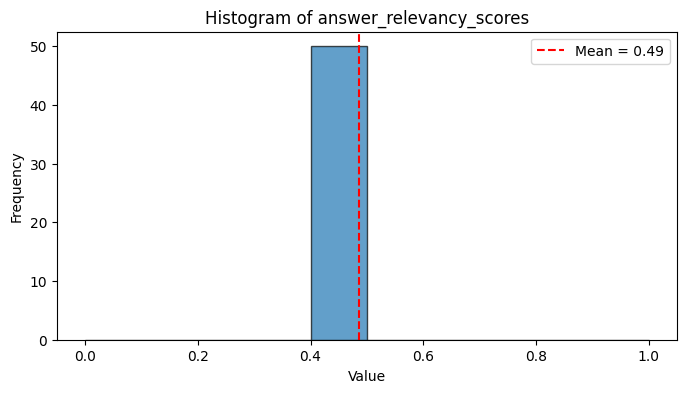

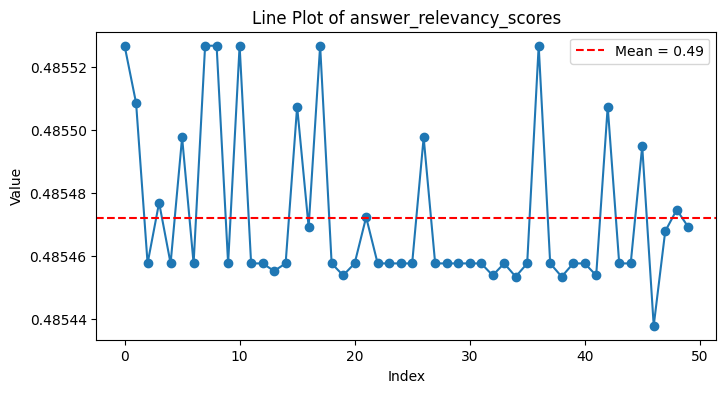

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean_val = np.mean(answer_relevancy_scores)
std_val = np.std(answer_relevancy_scores)

print(f"Mean: {mean_val:.4f}")
print(f"Standard Deviation: {std_val:.4f}")


plt.figure(figsize=(8, 4))
plt.hist(answer_relevancy_scores, bins=10, edgecolor='black', alpha=0.7, range=(0, 1))
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
plt.title('Histogram of answer_relevancy_scores')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot line plot
plt.figure(figsize=(8, 4))
plt.plot(answer_relevancy_scores, marker='o')
plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
plt.title('Line Plot of answer_relevancy_scores')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:
faith_result = []

In [17]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas import SingleTurnSample
from ragas.metrics import Faithfulness
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.ollama_creator import OllamaLangChainChatModelCreator
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator

gpt_4_1 = LangchainLLMWrapper(langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4.1").create_model())
context_precision_gpt_4_1 = Faithfulness(llm=gpt_4_1)

sample = SingleTurnSample(
    user_input=investigate["question"],
    response=investigate["response"],
    retrieved_contexts=investigate["retrieved_contexts"], 
)

for i in range(40):
    print(f"Running {i+1} of 10")
    result = await context_precision_gpt_4_1.single_turn_ascore(sample)
    faith_result.append(result)
    print(result)

faith_result

Running 1 of 10
0.625
Running 2 of 10
0.625
Running 3 of 10
0.625
Running 4 of 10
0.625
Running 5 of 10
0.625
Running 6 of 10
0.6363636363636364
Running 7 of 10
0.625
Running 8 of 10
0.625
Running 9 of 10
0.5
Running 10 of 10
0.6363636363636364
Running 11 of 10
0.625
Running 12 of 10
0.625
Running 13 of 10
0.5
Running 14 of 10
0.625
Running 15 of 10
0.625
Running 16 of 10
0.625
Running 17 of 10
0.625
Running 18 of 10
0.6363636363636364
Running 19 of 10
0.5
Running 20 of 10
0.625
Running 21 of 10
0.625
Running 22 of 10
0.5
Running 23 of 10
0.6363636363636364
Running 24 of 10
0.5
Running 25 of 10
0.6363636363636364
Running 26 of 10
0.5
Running 27 of 10
0.625
Running 28 of 10
0.625
Running 29 of 10
0.6363636363636364
Running 30 of 10
0.625
Running 31 of 10
0.625
Running 32 of 10
0.625
Running 33 of 10
0.4444444444444444
Running 34 of 10
0.625
Running 35 of 10
0.625
Running 36 of 10
0.6363636363636364
Running 37 of 10
0.625
Running 38 of 10
0.5
Running 39 of 10
0.5
Running 40 of 10
0.625


[0.625,
 0.625,
 0.625,
 0.625,
 0.5,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.6363636363636364,
 0.625,
 0.625,
 0.5,
 0.6363636363636364,
 0.625,
 0.625,
 0.5,
 0.625,
 0.625,
 0.625,
 0.625,
 0.6363636363636364,
 0.5,
 0.625,
 0.625,
 0.5,
 0.6363636363636364,
 0.5,
 0.6363636363636364,
 0.5,
 0.625,
 0.625,
 0.6363636363636364,
 0.625,
 0.625,
 0.625,
 0.4444444444444444,
 0.625,
 0.625,
 0.6363636363636364,
 0.625,
 0.5,
 0.5,
 0.625]

Mean: 0.6005
Standard Deviation: 0.0537


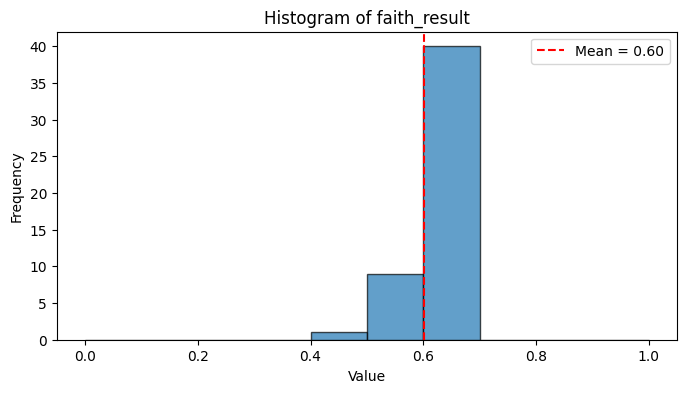

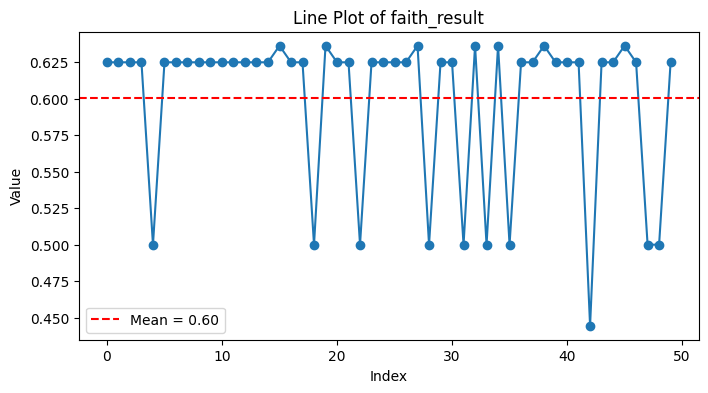

In [23]:
import matplotlib.pyplot as plt
import numpy as np

mean_val = np.mean(faith_result)
std_val = np.std(faith_result)

print(f"Mean: {mean_val:.4f}")
print(f"Standard Deviation: {std_val:.4f}")


plt.figure(figsize=(8, 4))
plt.hist(faith_result, bins=10, edgecolor='black', alpha=0.7, range=(0, 1))
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
plt.title('Histogram of faith_result')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot line plot
plt.figure(figsize=(8, 4))
plt.plot(faith_result, marker='o')
plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
plt.title('Line Plot of faith_result')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
faith_result.count(0.625)

33

In [23]:
from ragas.dataset_schema import SingleTurnSample 
from ragas.metrics import Faithfulness

ollama_deepseek_1_5b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:1.5b"))
ollama_deepseek_7b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:7b"))
ollama_deepseek_32b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:32b"))

sample = SingleTurnSample(
        user_input=investigate["question"],
        response=investigate["response"],
        retrieved_contexts=investigate["retrieved_contexts"]
    )
scorer = Faithfulness(llm=ollama_deepseek_7b)
await scorer.single_turn_ascore(sample)

1.0

In [32]:
import sys
sys.path.append("/Users/leonbartz/develop/uni/rag-eval")

from ragas.dataset_schema import SingleTurnSample 
from ragas.metrics import LLMContextPrecisionWithoutReference
from ragas.llms import LangchainLLMWrapper
from langchain_ollama import ChatOllama
from ragas import SingleTurnSample
from ragas.metrics import LLMContextPrecisionWithoutReference, LLMContextPrecisionWithReference
from ragas.llms import LangchainLLMWrapper
from app.chat_models.langchain.creator.ollama_creator import OllamaLangChainChatModelCreator
from app.chat_models.langchain.creator.openai_creator import OpenAILangChainChatModelCreator

async def eval_all_models_context_precision_ollama(investigate, host="http://127.0.0.1:11436"):
    ollama_deepseek_1_5b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:1.5b", base_url=host))
    ollama_deepseek_7b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:7b", base_url=host))
    ollama_deepseek_32b = LangchainLLMWrapper(langchain_llm=ChatOllama(model="deepseek-r1:32b", base_url=host))

    context_precision_ollama_deepseek_1_5b = LLMContextPrecisionWithoutReference(llm=ollama_deepseek_1_5b)
    context_precision_ollama_deepseek_7b = LLMContextPrecisionWithoutReference(llm=ollama_deepseek_7b)
    context_precision_ollama_deepseek_32b = LLMContextPrecisionWithoutReference(llm=ollama_deepseek_32b)

    sample = SingleTurnSample(
        user_input=investigate["question"],
        response=investigate["response"],
        retrieved_contexts=investigate["retrieved_contexts"]
    )

    return {
        "ollama_deepseek_1_5b": await context_precision_ollama_deepseek_1_5b.single_turn_ascore(sample),
        "ollama_deepseek_7b": await context_precision_ollama_deepseek_7b.single_turn_ascore(sample),
        "ollama_deepseek_32b": await context_precision_ollama_deepseek_32b.single_turn_ascore(sample)
    }


async def eval_all_models_context_precision_gpt(investigate):
    gpt_4_1 = LangchainLLMWrapper(langchain_llm=OpenAILangChainChatModelCreator("openai/gpt-4").create_model())
    context_precision_gpt_4_1 = LLMContextPrecisionWithoutReference(llm=gpt_4_1)

    sample = SingleTurnSample(
        user_input=investigate["question"],
        response=investigate["response"],
        retrieved_contexts=investigate["retrieved_contexts"]
    )

    return await context_precision_gpt_4_1.single_turn_ascore(sample)

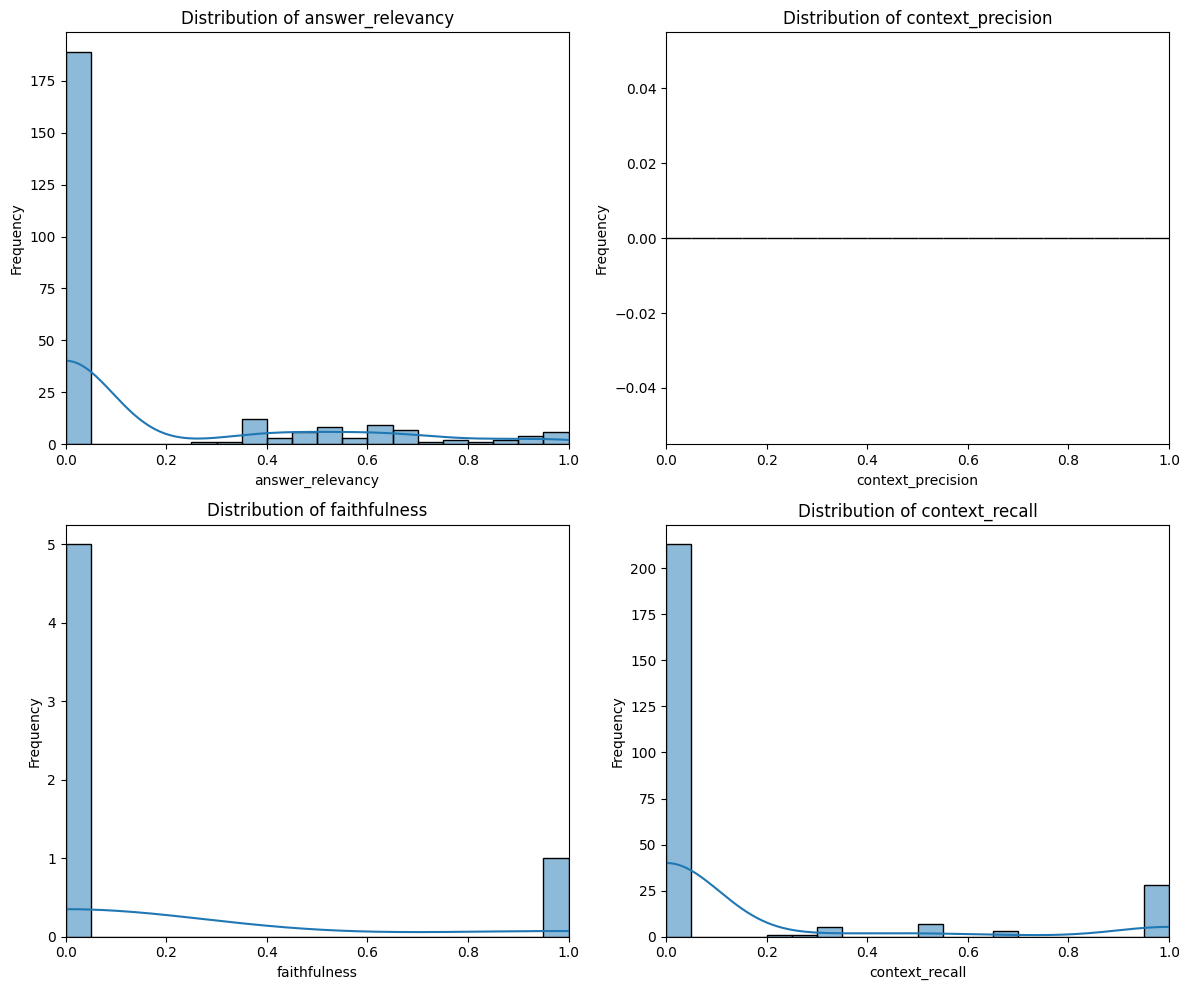

In [4]:
ratings_id = 22
rating, questions, scores = get_rating_data(ratings_id, host="http://localhost:9877")
df_merged_400_300_D_D = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_300_D_D)

In [15]:
df_merged_400_300_D_D[0:10]

,id,question,reference_answer,reference_context,conversation_history,metadata,user_input,retrieved_contexts,response,reference,answer_relevancy,context_precision,faithfulness,context_recall,raw_response
0,23e2a1cd-6384-4f94-ac02-ca8e3979dace,Welche Zahlungsmethoden akzeptieren Sie?,Wir akzeptieren eine Vielzahl von Zahlungsmeth...,"Document 3203: e=nc(t),n=e%1;return e==e?n?e-n...",[],"{'question_type': 'simple', 'seed_document_id'...",Welche Zahlungsmethoden akzeptieren Sie?,[Schlüsselaktivität:\n\n-Das weiterentwickeln ...,I don't know.,Wir akzeptieren eine Vielzahl von Zahlungsmeth...,0.000000,None,1.0,0.000000,"<think>\nOkay, ich muss die Frage ""Welche Zahl..."
1,61e23462-d64b-4779-9a85-07d88ea2cd34,Which payment methods do you accept?,"We accept major credit and debit cards (Visa, ...",Document 3343: document.documentElement&&0===e...,[],"{'question_type': 'simple', 'seed_document_id'...",Which payment methods do you accept?,[|\n | All authentication drivers have a us...,I don't know.,"We accept major credit and debit cards (Visa, ...",0.000000,None,0.0,0.000000,"<think>\nOkay, so I'm trying to answer the que..."
2,cd546d8b-94f1-44da-ba8d-07fc6586f44c,"Was passiert, wenn Elemente in section.content...",Wenn Elemente in section.content keine ID habe...,Document 349: return el != null;\n ...,[],"{'question_type': 'simple', 'seed_document_id'...","Was passiert, wenn Elemente in section.content...",[Kategorie: Passiva\nUnterkategorie: Verbindli...,I don't know.,Wenn Elemente in section.content keine ID habe...,0.000000,None,0.0,0.000000,"<think>\nOkay, I need to answer the question b..."
3,75ea7805-4709-49ab-9f83-d3a22bcfec0a,Wie kann ich meinen Auftrag verfolgen?,Sie können Ihren Auftrag entweder über die in ...,Document 1792: auto!important}.flex-sm-grow-0{...,[],"{'question_type': 'simple', 'seed_document_id'...",Wie kann ich meinen Auftrag verfolgen?,"[nicht im Interesse des Auftraggebers stehen, ...",I don't know.,Sie können Ihren Auftrag entweder über die in ...,0.000000,None,NaN,0.000000,"<think>\nOkay, let me try to figure out how to..."
4,83c7ec4c-c8df-4dd9-9e01-cd9ab58de758,What types of details can be viewed using the ...,The preview-screen component allows viewing Ca...,"Document 3446: strict"";n.r(e);var r={mixins:[n...",[],"{'question_type': 'simple', 'seed_document_id'...",What types of details can be viewed using the ...,"[,.show>.btn-outline-info.dropdown-toggle:focu...",The preview-screen component allows viewing th...,The preview-screen component allows viewing Ca...,1.000000,None,NaN,0.000000,"<think>\nOkay, I need to figure out what types..."
5,71aaec07-e68c-4384-a340-b72af5f433b6,For which countries can I track my shipping?,"We ship to all 50 US states, Canada, and Mexic...",Document 3399: p=function(){t.config.animation...,[],"{'question_type': 'simple', 'seed_document_id'...",For which countries can I track my shipping?,"[,""Europe/London|Europe/Jersey"",""Europe/London...","Based on the context provided, you can track y...","We ship to all 50 US states, Canada, and Mexic...",0.904199,None,NaN,0.000000,"<think>\nOkay, so I need to figure out for whi..."
6,f38c5911-ff1c-47b7-8a88-2f90d9f48a0a,Wie lauten die Angebotspreise Brutto und der b...,Angebotspreis Brutto 419.505213 mit einem kalk...,Document 5065: Angebotspreis Brutto 419.505213...,[],"{'question_type': 'simple', 'seed_document_id'...",Wie lauten die Angebotspreise Brutto und der b...,[Angebotspreis Brutto 96.424645 - Gewinnmarge ...,"Die Angebotspreise Brutto sind 96.424,64 und 4...",Angebotspreis Brutto 419.505213 mit einem kalk...,0.434867,None,NaN,1.000000,"<think>\nAlright, I'm trying to figure out the..."
7,c2928185-c121-42b5-b43c-b7cc73d7f8e1,Wer ist für die Lehrkräfte-Schulung am 10.06.2...,Die IT & Schulungsleitung sind für die Lehrkrä...,Document 4461: Meilenstein: Schulung Lehrkräft...,[],"{'question_type': 'simple', 'seed_document_id'...",Wer ist für die Lehrkräfte-Schulung am 10.06.2...,[Meilenstein: Schulung Lehrkräfte\nDatum: 202

In [29]:
investigate = get_entry_by_id(df_merged_400_300_D_D, "78ec47c2-0ac3-4526-b2b7-a295ca5556e9")
await eval_all_models_context_precision_ollama(investigate)

{'ollama_deepseek_1_5b': 0.0,
 'ollama_deepseek_7b': 0.0,
 'ollama_deepseek_32b': 0.0}

In [33]:
await eval_all_models_context_precision_gpt(investigate)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}